In [40]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor

In [2]:
def get_relative_positions(seq_len: int) -> torch.tensor:
    x = torch.arange(seq_len)[None, :]
    y = torch.arange(seq_len)[:, None]
    return x - y
get_relative_positions(8)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [-1,  0,  1,  2,  3,  4,  5,  6],
        [-2, -1,  0,  1,  2,  3,  4,  5],
        [-3, -2, -1,  0,  1,  2,  3,  4],
        [-4, -3, -2, -1,  0,  1,  2,  3],
        [-5, -4, -3, -2, -1,  0,  1,  2],
        [-6, -5, -4, -3, -2, -1,  0,  1],
        [-7, -6, -5, -4, -3, -2, -1,  0]])

In [139]:
def get_alibi_slope(n_heads):
    x = (2 ** 8) ** (1 / n_heads)
    return (
        torch.tensor([1 / x ** (i + 1) for i in range(n_heads)])
        .unsqueeze(-1)
        .unsqueeze(-1)
    )

m = get_alibi_slope(8)
m

tensor([[[0.5000]],

        [[0.2500]],

        [[0.1250]],

        [[0.0625]],

        [[0.0312]],

        [[0.0156]],

        [[0.0078]],

        [[0.0039]]])

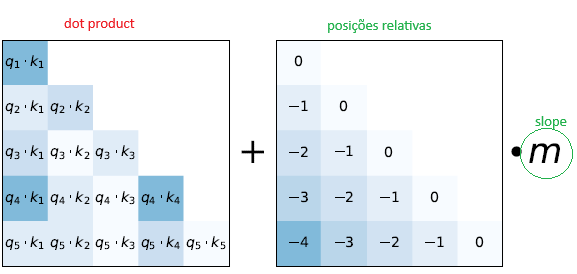

In [134]:
class AlibiMultiHeadAttention(nn.Module):
    def __init__(
        self,
        n_heads: int = 4,
        d_model: int = 8,
        dropout: float = 0.0,
        causal: bool = True
    ):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.register_buffer('m', get_alibi_slope(n_heads))
        self.causal  = causal
        self.dropout = nn.Dropout(p=dropout)
        if causal:
            self.register_buffer('mask', None)

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        N, L, _ = q.shape
        # k.shape = (batch_size, num_heads, d_head, seq_len)  Já faz o transpose
        k = k.view(N, L, self.n_heads, -1).permute(0, 2, 3, 1)
        # q, v.shape = (batch_size, num_heads, seq_len, d_head)
        q = q.view(N, L, self.n_heads, -1).transpose(1, 2)
        v = v.view(N, L, self.n_heads, -1).transpose(1, 2)

        # bias.shape == (1, num_heads, seq_len, seq_len)
        bias = (self.m * get_relative_positions(L)).unsqueeze(0)
        
        score = torch.matmul(q, k) / math.sqrt(self.d_model) + bias  # ALiBi
        if self.causal:
            mask = torch.triu(torch.ones(1, 1, L, L, device=q.device), diagonal=1).bool()
            score = score.masked_fill(mask, float("-inf"))
        attn = F.softmax(score, dim=-1)
        # out.shape == (batch_size, num_heads, seq_len, d_head)
        out = torch.matmul(attn, v)
        # out.shape == (batch_size, seq_len, d_model)
        out = out.transpose(1, 2).reshape(N, L, -1)
        return self.dropout(out)

In [129]:
alibi = AlibiMultiHeadAttention()

In [135]:
N, L, D_MODEL = 1, 8, 8
q = torch.rand((N, L, D_MODEL))
k = torch.rand((N, L, D_MODEL))
v = torch.rand((N, L, D_MODEL))

In [136]:
v

tensor([[[0.2110, 0.8788, 0.7767, 0.8220, 0.2568, 0.7290, 0.1174, 0.3972],
         [0.3550, 0.7625, 0.9296, 0.7119, 0.9096, 0.6925, 0.2928, 0.6532],
         [0.1107, 0.1949, 0.6302, 0.0925, 0.4314, 0.7276, 0.4924, 0.6320],
         [0.1398, 0.5211, 0.2965, 0.5895, 0.0365, 0.3329, 0.9813, 0.3096],
         [0.1076, 0.7596, 0.5658, 0.6616, 0.9928, 0.0593, 0.3506, 0.1504],
         [0.0448, 0.0106, 0.9588, 0.3325, 0.4013, 0.8090, 0.2202, 0.7384],
         [0.2706, 0.6885, 0.8375, 0.5863, 0.4585, 0.0746, 0.0925, 0.4602],
         [0.7515, 0.0803, 0.0722, 0.1909, 0.8395, 0.6541, 0.3646, 0.1939]]])

In [137]:
# Para um decoder com causal = True
alibi(q, k, v)

tensor([[[0.2551, 0.4899, 0.6110, 0.5032, 0.5329, 0.4868, 0.3741, 0.4306],
         [0.2515, 0.4663, 0.6166, 0.4853, 0.5301, 0.5141, 0.3490, 0.4453],
         [0.2626, 0.4730, 0.6041, 0.4910, 0.5447, 0.4859, 0.3753, 0.4194],
         [0.2602, 0.4816, 0.6219, 0.4971, 0.5316, 0.5049, 0.3593, 0.4394],
         [0.2506, 0.4664, 0.6120, 0.4851, 0.5136, 0.4959, 0.3646, 0.4509],
         [0.2599, 0.4763, 0.6145, 0.4923, 0.5431, 0.4860, 0.3643, 0.4277],
         [0.2473, 0.4624, 0.6128, 0.4833, 0.5241, 0.4957, 0.3673, 0.4418],
         [0.2483, 0.4588, 0.6185, 0.4807, 0.5335, 0.4939, 0.3663, 0.4329]]])

In [138]:
# Para um encoder com causal = False
alibi = AlibiMultiHeadAttention(causal=False)
alibi(q, k, v)

tensor([[[0.3221, 0.3950, 0.6289, 0.4958, 0.5410, 0.5065, 0.3798, 0.4309],
         [0.3164, 0.3939, 0.6228, 0.4854, 0.5496, 0.5074, 0.3656, 0.4488],
         [0.3188, 0.3933, 0.6205, 0.4887, 0.5480, 0.5071, 0.3809, 0.4298],
         [0.3139, 0.3925, 0.6244, 0.4954, 0.5481, 0.5071, 0.3706, 0.4435],
         [0.3192, 0.3948, 0.6231, 0.4838, 0.5347, 0.5062, 0.3762, 0.4384],
         [0.3198, 0.3964, 0.6224, 0.4884, 0.5386, 0.5066, 0.3778, 0.4268],
         [0.3142, 0.3906, 0.6233, 0.4857, 0.5403, 0.5065, 0.3755, 0.4377],
         [0.3109, 0.3898, 0.6219, 0.4856, 0.5452, 0.5070, 0.3768, 0.4361]]])